In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import cudf
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.svm import SVC as cuSVC
from cuml.ensemble import RandomForestClassifier as cuRF
import xgboost as xgb
from imblearn.over_sampling import BorderlineSMOTE

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmedakram1","key":"b04ee0dd1f56cfa8140b1e349b641f08"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Preprocessing

In [7]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [10]:
df['Class'].value_counts()/float(len(df))

,count
Class,
0,0.998273
1,0.001727


In [11]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [12]:
round(df.describe(),2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [13]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

In [15]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Before:", y_train.value_counts())
print("After:", y_res.value_counts())

Before: Class
0    227451
1       394
Name: count, dtype: int64
After: Class
0    227451
1    227451
Name: count, dtype: int64


In [16]:
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

In [17]:
correlation = df.corr()

In [18]:
correlation['Class'].sort_values(ascending=False)

,Class
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090
V8,0.019875
V27,0.017580
V28,0.009536


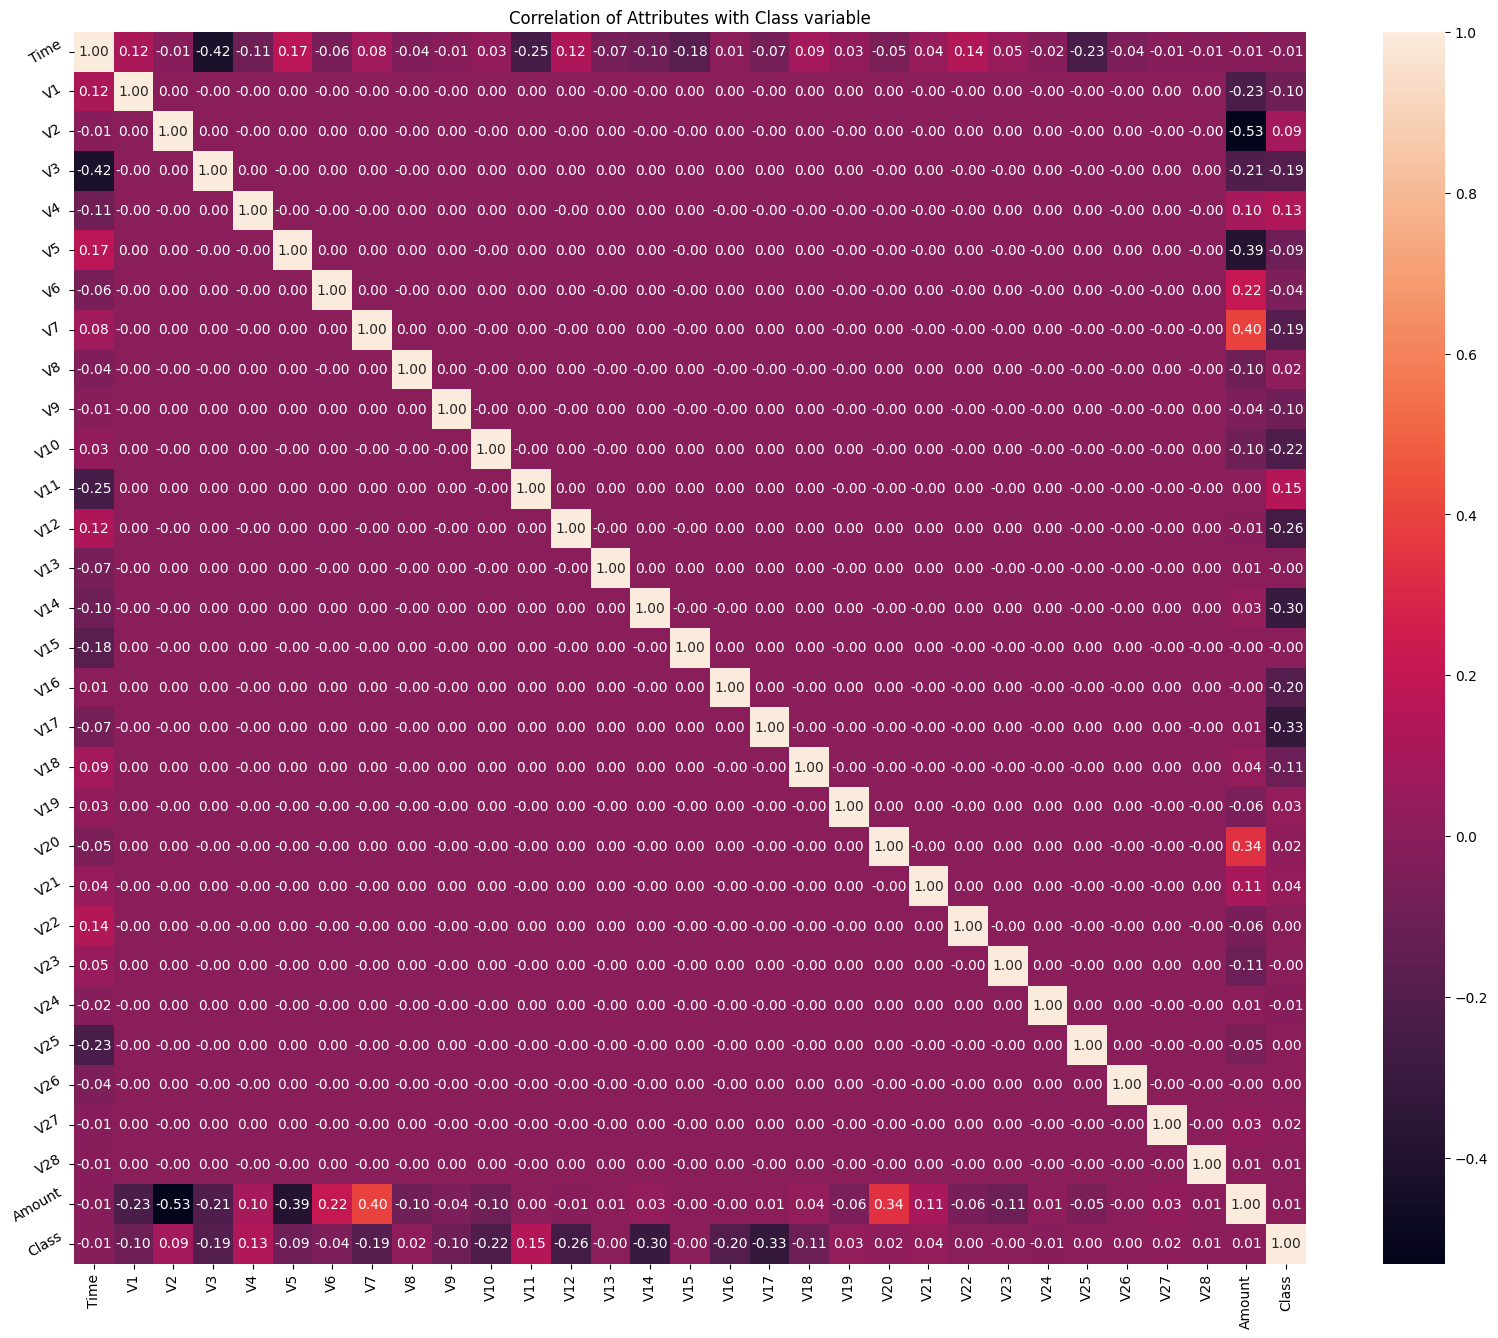

In [19]:
plt.figure(figsize=(20,16))
plt.title('Correlation of Attributes with Class variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

# First we will Run on the biased data without the smote, Please Note!! this will take too much time to run cuz we are running these models on the cpu so it's better to jump to the part where we used GPU below where the highest Accuracy is there already using XGBoost

## Great let's try KNN first

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

### This is the Accuracy Score at n = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

y_pred

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

### n = 5

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=5)

# knn.fit(X_train, y_train)

# y_pred_not_scaled_n5 = knn.predict(X_test)

# y_pred_not_scaled_n5

In [ ]:
# from sklearn.metrics import accuracy_score

# print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_not_scaled_n5)))

### Conclusion for KNN
As we saw if we scaled our data or not, Changed the number of neighbors or not, there is no change that affects our accuracy **score**

## Great now let's try SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

In [ ]:
# instantiate classifier with rbf kernel and C=100
# svc=SVC(C=100.0)

# svc.fit(X_train,y_train)

# y_pred=svc.predict(X_test)

In [ ]:
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))

In [ ]:
# instantiate classifier with rbf kernel and C=1000
# svc=SVC(C=1000.0)

# svc.fit(X_train,y_train)

# y_pred=svc.predict(X_test)

In [ ]:
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))

In [ ]:
# instantiate classifier with linear kernel and C=1.0
# linear_svc=SVC(kernel='linear', C=1.0)

# linear_svc.fit(X_train,y_train)

# y_pred_test=linear_svc.predict(X_test)

In [ ]:
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))

In [ ]:
# instantiate classifier with linear kernel and C=100.0
# linear_svc100=SVC(kernel='linear', C=100.0)

# linear_svc100.fit(X_train, y_train)

# y_pred=linear_svc100.predict(X_test)

In [ ]:
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))

In [ ]:
# instantiate classifier with linear kernel and C=1000.0
# linear_svc1000=SVC(kernel='linear', C=1000.0)

# linear_svc1000.fit(X_train, y_train)

# y_pred=linear_svc1000.predict(X_test)

In [ ]:
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1 Score:", f1_score(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42, max_depth=None, class_weight="balanced")
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [ ]:
print("\n Decision Tree Results")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_dt))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
print("\n Random Forest Results")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

#Great now let's try using Smote running on GPU


## KNN

In [20]:
import torch
torch.cuda.is_available()

True

In [21]:
!nvidia-smi
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com


Fri Sep  5 19:26:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
# Convert NumPy arrays to pandas DataFrame
X_train_pd = pd.DataFrame(X_res_scaled, columns=X.columns)
X_test_pd = pd.DataFrame(X_test_scaled, columns=X.columns)

y_train_pd = pd.Series(y_res)

# Convert pandas to cuDF
X_train_cu = cudf.DataFrame.from_pandas(X_train_pd)
X_test_cu = cudf.DataFrame.from_pandas(X_test_pd)
y_train_cu = cudf.Series(y_train_pd)

# Train KNN on GPU
knn = cuKNN(n_neighbors=1, weights="uniform")
knn.fit(X_train_cu, y_train_cu)

# Predict and convert back to pandas
y_pred_cu = knn.predict(X_test_cu).to_pandas()

In [23]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cu))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cu))

print("Precision:", precision_score(y_test, y_pred_cu))
print("Recall:", recall_score(y_test, y_pred_cu))
print("F1 Score:", f1_score(y_test, y_pred_cu))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_cu))

Confusion Matrix:
 [[56831    33]
 [   20    78]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.80      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.7027027027027027
Recall: 0.7959183673469388
F1 Score: 0.7464114832535885
ROC-AUC: 0.89766901766334


In [24]:
svm = cuSVC(kernel='rbf', C=1.0)
svm.fit(X_train_cu, y_train_cu)
y_pred_svm = svm.predict(X_test_cu).to_pandas()


In [25]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_svm))

Confusion Matrix:
 [[56731   133]
 [   18    80]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.82      0.51        98

    accuracy                           1.00     56962
   macro avg       0.69      0.91      0.76     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.3755868544600939
Recall: 0.8163265306122449
F1 Score: 0.5144694533762058
ROC-AUC: 0.9069938083562068


In [26]:
# For Decision Tree we will use n_estimators=1
dt = cuRF(n_estimators=1, max_depth=10, random_state=42)
dt.fit(X_train_cu, y_train_cu)

y_pred_dt = dt.predict(X_test_cu).to_pandas()


In [27]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_dt))

Confusion Matrix:
 [[56060   804]
 [   14    84]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.86      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.92      0.58     56962
weighted avg       1.00      0.99      0.99     56962

Precision: 0.0945945945945946
Recall: 0.8571428571428571
F1 Score: 0.17038539553752535
ROC-AUC: 0.921501929415548


In [28]:
rf = cuRF(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_cu, y_train_cu)
y_pred_rf = rf.predict(X_test_cu).to_pandas()


In [29]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

Confusion Matrix:
 [[56810    54]
 [   11    87]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.62      0.89      0.73        98

    accuracy                           1.00     56962
   macro avg       0.81      0.94      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.6170212765957447
Recall: 0.8877551020408163
F1 Score: 0.7280334728033473
ROC-AUC: 0.9434027339129236


## Trying XGBoost

In [30]:
!pip install xgboost --upgrade

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

In [32]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),  # handle imbalance
    tree_method='gpu_hist',  # use GPU
    random_state=42
)

model.fit(X_res_scaled, y_res)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:27:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [19:27:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [19:27:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is runnin

In [33]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[56835    29]
 [   15    83]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.85      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.7410714285714286
Recall: 0.8469387755102041
F1 Score: 0.7904761904761904
ROC-AUC: 0.9853074970139997


#Implementing XGBoost without smote just scaling

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    tree_method='gpu_hist',
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:33:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [19:33:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [47]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[56861     3]
 [   17    81]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.9642857142857143
Recall: 0.826530612244898
F1 Score: 0.8901098901098901
ROC-AUC: 0.9826957337521389


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Approach 1: Class-weighted XGBoost (no resampling)
print("=== Approach 1: Class-weighted XGBoost ===")
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

model_cw = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    tree_method='gpu_hist',
    random_state=42
)

model_cw.fit(X_train_scaled, y_train)
y_pred_cw = model_cw.predict(X_test_scaled)
y_proba_cw = model_cw.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cw))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cw))
print("Precision:", precision_score(y_test, y_pred_cw))
print("Recall:", recall_score(y_test, y_pred_cw))
print("F1 Score:", f1_score(y_test, y_pred_cw))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cw))

=== Approach 1: Class-weighted XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:29:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[56854    10]
 [   16    82]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.8913043478260869
Recall: 0.8367346938775511
F1 Score: 0.8631578947368421
ROC-AUC: 0.9663994220366818


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [19:29:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [41]:
print("\n=== Approach 2: Borderline-SMOTE + XGBoost ===")
smote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

model_smote = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    tree_method='gpu_hist',
    random_state=42
)

model_smote.fit(X_res, y_res)
y_pred_smote = model_smote.predict(X_test_scaled)
y_proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("Precision:", precision_score(y_test, y_pred_smote))
print("Recall:", recall_score(y_test, y_pred_smote))
print("F1 Score:", f1_score(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_smote))


=== Approach 2: Borderline-SMOTE + XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:29:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[56850    14]
 [   19    79]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.81      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.8494623655913979
Recall: 0.8061224489795918
F1 Score: 0.8272251308900523
ROC-AUC: 0.9730831098618401


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [19:29:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [42]:
print("\n=== Approach 3: Threshold tuning on class-weighted XGBoost ===")
threshold = 0.2
y_pred_thresh = (y_proba_cw > threshold).astype(int)

# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cw))


=== Approach 3: Threshold tuning on class-weighted XGBoost ===
Confusion Matrix:
 [[56848    16]
 [   15    83]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.85      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.8383838383838383
Recall: 0.8469387755102041
F1 Score: 0.8426395939086294
ROC-AUC: 0.9663994220366818


#Summary
 as we see after trying  Class-weighted XGBoost (no resampling), Borderline-SMOTE + XGBoost, Threshold tuning on class-weighted XGBoost and Implementing XGBoost without smote just scaling the best one was XGBoost without smote just scaling with f1 score of 0.89

 the first part in the notebook where we ran on the cpu the best model was the knn with f1 score of 0.85

## These are the metrics for our best model XGBoost with just scaling

In [48]:
y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

print("=== Train Metrics ===")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))
print("ROC-AUC:", roc_auc_score(y_train, y_train_proba))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

print("\n=== Test Metrics ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
train_roc = roc_auc_score(y_train, y_train_proba)
test_roc = roc_auc_score(y_test, y_proba)

print("\nF1 Score: Train = {:.4f}, Test = {:.4f}".format(train_f1, test_f1))
print("ROC-AUC: Train = {:.4f}, Test = {:.4f}".format(train_roc, test_roc))


=== Train Metrics ===
Confusion Matrix:
 [[227451      0]
 [     0    394]]
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
Recall: 1.0

=== Test Metrics ===
Confusion Matrix:
 [[56861     3]
 [   17    81]]
F1 Score: 0.8901098901098901
ROC-AUC: 0.9826957337521389
Precision: 0.9642857142857143
Recall: 0.826530612244898

F1 Score: Train = 1.0000, Test = 0.8901
ROC-AUC: Train = 1.0000, Test = 0.9827


## As we see our model is a bit overfitting let's try to fix this by making our model more simple, Early stopping and adding Regularization!

In [104]:
# Convert data to DMatrix (XGBoost’s native format)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest  = xgb.DMatrix(X_test_scaled, label=y_test)

# Parameters (GPU + L2 regularization)
params = {
    "objective": "binary:logistic",
    "max_depth": 6,
    "eta": 0.1,               # learning rate
    "tree_method": "gpu_hist",
    "lambda": 5,              # L2 regularization
    "scale_pos_weight": (len(y_train)-sum(y_train))/sum(y_train),
    "eval_metric": "auc"
}

# Train with early stopping
evals = [(dtrain, "train"), (dtest, "eval")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False  # don't print training progress
)

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [20:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


In [105]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

# -------------------------
# Train set metrics
# -------------------------
y_train_pred = (bst.predict(dtrain) > 0.5).astype(int)
y_train_proba = bst.predict(dtrain)

print("=== Train Metrics ===")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))
print("ROC-AUC:", roc_auc_score(y_train, y_train_proba))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

# -------------------------
# Test set metrics
# -------------------------
y_test_pred = (bst.predict(dtest) > 0.5).astype(int)
y_test_proba = bst.predict(dtest)

print("\n=== Test Metrics ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))

# -------------------------
# Train vs Test summary
# -------------------------
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_roc = roc_auc_score(y_train, y_train_proba)
test_roc = roc_auc_score(y_test, y_test_proba)

print("\nF1 Score: Train = {:.4f}, Test = {:.4f}".format(train_f1, test_f1))
print("ROC-AUC: Train = {:.4f}, Test = {:.4f}".format(train_roc, test_roc))


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [20:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


=== Train Metrics ===
Confusion Matrix:
 [[227437     14]
 [     0    394]]
F1 Score: 0.9825436408977556
ROC-AUC: 1.0
Precision: 0.9656862745098039
Recall: 1.0

=== Test Metrics ===
Confusion Matrix:
 [[56860     4]
 [   15    83]]
F1 Score: 0.8972972972972973
ROC-AUC: 0.9794122101569948
Precision: 0.9540229885057471
Recall: 0.8469387755102041

F1 Score: Train = 0.9825, Test = 0.8973
ROC-AUC: Train = 1.0000, Test = 0.9794


# These are the best results I could reach after adjusting the hyperparameters, trying to make the model simpler adding L2 and adding early stopping I hope this helps someone! Thanks for your time!